In [1]:
!pip install chess

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 1.9 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import chess
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers

In [5]:
os.chdir('/content/drive/MyDrive/')
df = pd.read_csv('games_data.csv')
data = df['moves'].tolist()
split_data = []
indice = 500

In [6]:
chess_dict = {
    'p' : [1,0,0,0,0,0,0,0,0,0,0,0],
    'P' : [0,0,0,0,0,0,1,0,0,0,0,0],
    'n' : [0,1,0,0,0,0,0,0,0,0,0,0],
    'N' : [0,0,0,0,0,0,0,1,0,0,0,0],
    'b' : [0,0,1,0,0,0,0,0,0,0,0,0],
    'B' : [0,0,0,0,0,0,0,0,1,0,0,0],
    'r' : [0,0,0,1,0,0,0,0,0,0,0,0],
    'R' : [0,0,0,0,0,0,0,0,0,1,0,0],
    'q' : [0,0,0,0,1,0,0,0,0,0,0,0],
    'Q' : [0,0,0,0,0,0,0,0,0,0,1,0],
    'k' : [0,0,0,0,0,1,0,0,0,0,0,0],
    'K' : [0,0,0,0,0,0,0,0,0,0,0,1],
    '.' : [0,0,0,0,0,0,0,0,0,0,0,0],
}
alpha_dict = {
    'a' : [0,0,0,0,0,0,0],
    'b' : [1,0,0,0,0,0,0],
    'c' : [0,1,0,0,0,0,0],
    'd' : [0,0,1,0,0,0,0],
    'e' : [0,0,0,1,0,0,0],
    'f' : [0,0,0,0,1,0,0],
    'g' : [0,0,0,0,0,1,0],
    'h' : [0,0,0,0,0,0,1],
}
number_dict = {
    1 : [0,0,0,0,0,0,0],
    2 : [1,0,0,0,0,0,0],
    3 : [0,1,0,0,0,0,0],
    4 : [0,0,1,0,0,0,0],
    5 : [0,0,0,1,0,0,0],
    6 : [0,0,0,0,1,0,0],
    7 : [0,0,0,0,0,1,0],
    8 : [0,0,0,0,0,0,1],
}

In [7]:
def make_matrix(board):
    pgn = board.epd()
    foo = []
    pieces = pgn.split(" ", 1)[0]
    rows = pieces.split("/")
    for row in rows:
        foo2 = []
        for thing in row:
            if thing.isdigit():
                for i in range(0, int(thing)):
                    foo2.append('.')
            else:
                foo2.append(thing)
        foo.append(foo2)
    return foo
def translate(matrix,chess_dict):
    rows = []
    for row in matrix:
        terms = []
        for term in row:
            terms.append(chess_dict[term])
        rows.append(terms)
    return rows

In [8]:
for point in data[:indice]:
    point = point.split()
    split_data.append(point)

data = []
for game in split_data:
    board = chess.Board()
    for move in game:
        board_ready = board.copy()
        data.append(board.copy())
        board.push_san(move)
trans_data = []
for board in data:
    matrix = make_matrix(board)
    trans = translate(matrix,chess_dict)
    trans_data.append(trans)
pieces = []
alphas = []
numbers = []

In [9]:
# Define a flatten function to flatten a nested list
def flatten(lst):
    flat_list = []
    for sublist in lst:
        for item in sublist:
            flat_list.append(item)
    return flat_list

true_data = flatten(split_data)
for i in range(len(true_data)):
    try:
        term = flatten(split_data)[i]
        original = term[:]
        term = term.replace('x','')
        term = term.replace('#','')
        term = term.replace('+','')
        if len(term) == 2:
            piece = 'p'
        else:
            piece = term[0]
        alpha = term[-2]
        number = term[-1]
        pieces.append(chess_dict[piece])
        alphas.append(alpha_dict[alpha])
        numbers.append(number_dict[int(number)])
    except:
        pass

In [ ]:
board_inputs = keras.Input(shape=(8, 8, 12))
conv1 = layers.Conv2D(1024, 3, activation='relu')
conv2 = layers.Conv2D(512, 3, activation='relu')
pooling1 = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid", data_format=None)
pooling2 = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid", data_format=None)
flatten = keras.layers.Flatten(data_format=None)
x = conv1(board_inputs)
x = pooling1(x)
x = conv2(x)
x = flatten(x)
piece_output = layers.Dense(12, name='piece')(x)
model_pieces = keras.Model(inputs=board_inputs, outputs=piece_output, name="chess_ai_v3")
earlystop = keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, patience=250, verbose=0, mode='auto', baseline=None, restore_best_weights=True)
model_pieces.compile(
    loss=keras.losses.mse,
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy'],
)

board_inputs = keras.Input(shape=(8, 8, 12))
conv1 = layers.Conv2D(1024, 3, activation='relu')
conv2 = layers.Conv2D(512, 3, activation='relu')
pooling1 = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid", data_format=None)
pooling2 = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid", data_format=None)
flatten = keras.layers.Flatten(data_format=None)
x = conv1(board_inputs)
x = pooling1(x)
x = conv2(x)
x = flatten(x)
alpha_output = layers.Dense(7, name='alpha')(x)
model_alpha = keras.Model(inputs=board_inputs, outputs=alpha_output, name="chess_ai_v3")
earlystop = keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, patience=250, verbose=0, mode='auto', baseline=None, restore_best_weights=True)
model_alpha.compile(
    loss=keras.losses.mse,
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy'],
)

board_inputs = keras.Input(shape=(8, 8, 12))
conv1 = layers.Conv2D(1024, 3, activation='relu')
conv2 = layers.Conv2D(512, 3, activation='relu')
pooling1 = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid", data_format=None)
pooling2 = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid", data_format=None)
flatten = keras.layers.Flatten(data_format=None)
x = conv1(board_inputs)
x = pooling1(x)
x = conv2(x)
x = flatten(x)
numbers_output = layers.Dense(7, name='number')(x)
model_number = keras.Model(inputs=board_inputs, outputs=numbers_output, name="chess_ai_v3")
earlystop = keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, patience=250, verbose=0, mode='auto', baseline=None, restore_best_weights=True)
model_number.compile(
    loss=keras.losses.mse,
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy'],
)


Epoch 1/100
576/576 [==============================] - 7s 11ms/step - loss: 0.0697 - accuracy: 0.2229
Epoch 2/100
576/576 [==============================] - 6s 10ms/step - loss: 0.0673 - accuracy: 0.2635
Epoch 3/100
576/576 [==============================] - 6s 10ms/step - loss: 0.0656 - accuracy: 0.2983
Epoch 4/100
576/576 [==============================] - 6s 10ms/step - loss: 0.0639 - accuracy: 0.3329
Epoch 5/100
576/576 [==============================] - 6s 10ms/step - loss: 0.0621 - accuracy: 0.3633
Epoch 6/100
576/576 [==============================] - 6s 10ms/step - loss: 0.0605 - accuracy: 0.3872
Epoch 7/100
576/576 [==============================] - 6s 10ms/step - loss: 0.0588 - accuracy: 0.4124
Epoch 8/100
576/576 [==============================] - 6s 10ms/step - loss: 0.0571 - accuracy: 0.4373
Epoch 9/100
576/576 [==============================] - 6s 10ms/step - loss: 0.0557 - accuracy: 0.4578
Epoch 10/100
576/576 [==============================] - 6s 10ms/step - loss: 0.054

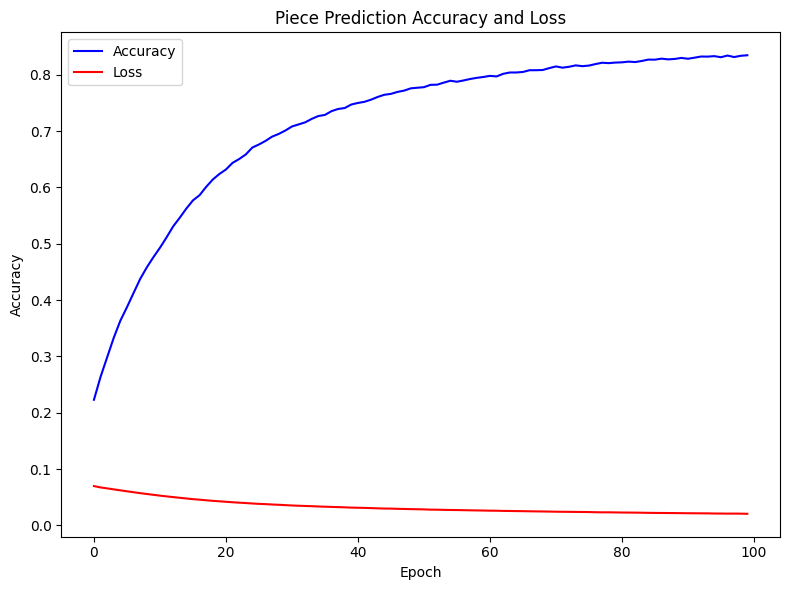

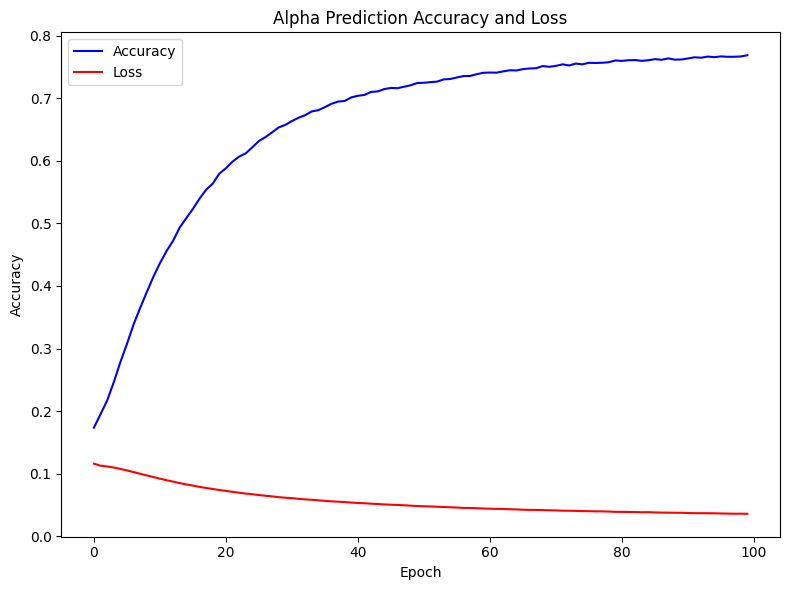

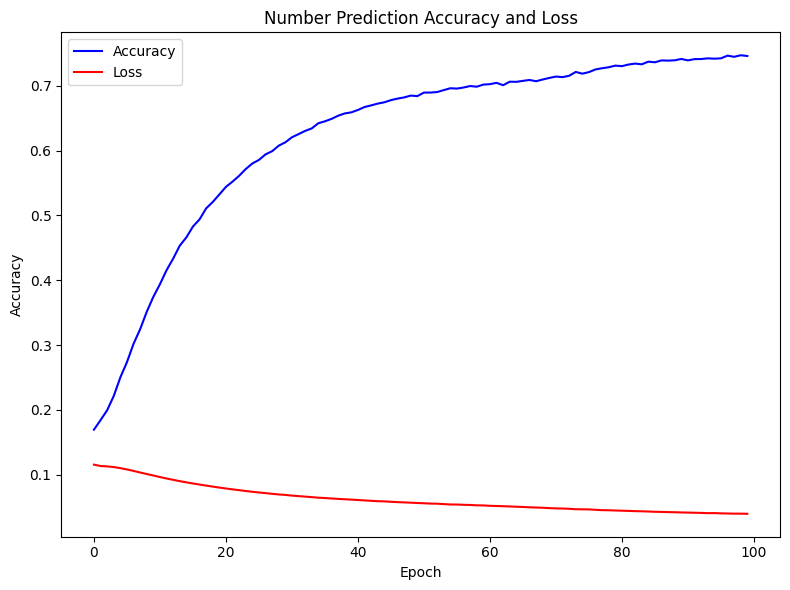

In [ ]:
import matplotlib.pyplot as plt

def plot_accuracy_loss(history, title):
    plt.figure(figsize=(8, 6))

    # Plot Accuracy
    plt.plot(history.history['accuracy'], label='Accuracy', color='blue')
    plt.title(f'{title} Accuracy and Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    # Plot Loss on the same graph
    plt.plot(history.history['loss'], label='Loss', color='red')
    plt.legend()

    plt.tight_layout()

# Training history for piece prediction model
piece_history = model_pieces.fit(
    trans_data[:len(pieces)],
    pieces[:len(pieces)],
    batch_size=64,
    epochs=100,
    callbacks=[earlystop],
)

# Training history for alpha prediction model
alpha_history = model_alpha.fit(
    trans_data[:len(alphas)],
    alphas[:len(alphas)],
    batch_size=64,
    epochs=100,
    callbacks=[earlystop],
)

# Training history for number prediction model
number_history = model_number.fit(
    trans_data[:len(numbers)],
    numbers[:len(numbers)],
    batch_size=64,
    epochs=100,
    callbacks=[earlystop],
)

# Plot accuracy and loss graphs for each model
plot_accuracy_loss(piece_history, 'Piece Prediction')
plt.show()

plot_accuracy_loss(alpha_history, 'Alpha Prediction')
plt.show()

plot_accuracy_loss(number_history, 'Number Prediction')
plt.show()


In [ ]:
new_chess_dict = {}
new_alpha_dict = {}
new_number_dict = {}
for term in chess_dict:
    definition = tuple(chess_dict[term])
    new_chess_dict[definition] = term
    new_chess_dict[term] = definition

for term in alpha_dict:
    definition = tuple(alpha_dict[term])
    new_alpha_dict[definition] = term
    new_alpha_dict[term] = definition

for term in number_dict:
    definition = tuple(number_dict[term])
    new_number_dict[definition] = term
    new_number_dict[term] = definition
data = np.reshape(trans_data[0],(1,8,8,12))
pred = model_pieces.predict(data)
def translate_pred(pred):
    translation = np.zeros(pred.shape)
    index = pred[0].tolist().index(max(pred[0]))
    translation[0][index] = 1
    return translation[0]
piece = translate_pred(model_pieces.predict(data))
alpha = translate_pred(model_alpha.predict(data))
number = translate_pred(model_alpha.predict(data))
piece_pred = new_chess_dict[tuple(piece)]
alpha_pred = new_alpha_dict[tuple(alpha)]
number_pred = new_number_dict[tuple(number)]
move =str(piece_pred)+str(alpha_pred)+str(number_pred)

1/1 [==============================] - 0s 17ms/step


In [ ]:
# Assuming you've already trained your models and assigned them to variables
model_pieces.save('/content/drive/MyDrive/piece_model.h5')
model_alpha.save('/content/drive/MyDrive/alpha_model.h5')
model_number.save('/content/drive/MyDrive/number_model.h5')


In [29]:
import chess
import numpy as np
from tensorflow import keras

# Load the trained models (you need to load the correct weights and architecture)
piece_model = keras.models.load_model('/content/drive/MyDrive/piece_model.h5')
alpha_model = keras.models.load_model('/content/drive/MyDrive/alpha_model.h5')
number_model = keras.models.load_model('/content/drive/MyDrive/number_model.h5')

# Define a dictionary to map piece class indices to their corresponding FEN representations
piece_dict = {0: 'p', 1: 'r', 2: 'n', 3: 'b', 4: 'q', 5: 'k', 6: 'P', 7: 'R', 8: 'N', 9: 'B', 10: 'Q', 11: 'K'}

# Define a function to preprocess the board
def preprocess_board(board):
    matrix = make_matrix(board)
    encoded_board = translate(matrix, chess_dict)
    return np.expand_dims(encoded_board, axis=0)

# Define a function to predict the best move from a FEN string
def predict_best_move(fen_board):
    board = chess.Board(fen_board)

    # Initialize variables to keep track of the best move and its probability
    best_move = None
    best_move_probability = -1.0  # Set to a low value

    # Iterate through all legal moves and predict their probabilities
    for move in board.legal_moves:
        board.push(move)
        input_data = preprocess_board(board)

        predicted_piece = piece_model.predict(input_data)
        predicted_alpha = alpha_model.predict(input_data)
        predicted_number = number_model.predict(input_data)

        # Convert predicted values to strings for comparison
        piece_idx = np.argmax(predicted_piece)
        alpha_idx = np.argmax(predicted_alpha)
        number_idx = np.argmax(predicted_number)

        predicted_move = f"{chess.SQUARE_NAMES[move.from_square]}{chess.SQUARE_NAMES[move.to_square]}"

        # Calculate a move score based on your criteria (e.g., piece type, alpha, number)
        move_score = predicted_piece[0][piece_idx] + predicted_alpha[0][alpha_idx] + predicted_number[0][number_idx]

        if move_score > best_move_probability:
            best_move = predicted_move
            best_move_probability = move_score

        # Undo the move to consider the next legal move
        board.pop()

    return best_move


fen_board = 'r1bqkbnr/ppp2ppp/2n5/3Bp3/4P3/5Q2/PPPP1PPP/RNB1K1NR b KQkq - 0 1'
best_move = predict_best_move(fen_board)
print("Best next move:", best_move)


1/1 [==============================] - 0s 21ms/step
Best next move: c8e6
